In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re
from scipy.io import loadmat
import scipy.signal as sp
import scipy.optimize as op
import nanosphere_utils as ns
import importlib
from matplotlib.backends.backend_pdf import PdfPages

In [58]:
data_path = '/Users/dcmoore/Desktop/nanosphere_data/' #"/Volumes/DATA/nanosphere_data"

data_folder = '20240724_minus_one_e_data/20240724_150v_1_8e-8mbar'

plots_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/nanospheres/analysis'


In [59]:
combined_path = os.path.join(data_path, data_folder, '**/*.mat')
data_files = glob.glob(combined_path, recursive=True)

In [60]:
print(data_files)

['/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0002/20240724-0002_4.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0002/20240724-0002_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0002/20240724-0002_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0002/20240724-0002_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0005/20240724-0005_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0005/20240724-0005_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0005/20240724-0005_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_150v_1_8e-8mbar/20240724-0005/20240

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_50671/3883218119.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time = np.arange(0, len(sphere_z)*tstep, tstep)


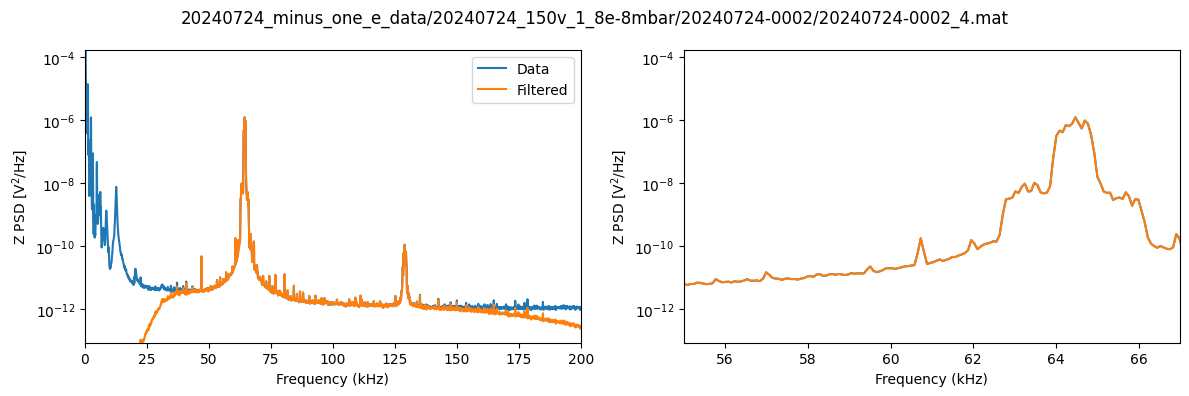

Working on impulse at time:  0.2240026026177162
45.907529337982616 12
Working on impulse at time:  0.5239998061235127
42.597909694752005 7
Working on impulse at time:  0.8239970096293092
47.17860818443701 9
Working on impulse at time:  1.1239942131351057
54.63098303581574 7
Working on impulse at time:  1.4239914166409022
44.622166939838316 12
Working on impulse at time:  1.7239886201466987
53.1386290167879 8
Working on noise at time:  0.4490004052470624
5.160452245377079 13
Working on noise at time:  0.7489976087528589
4.0764947424784035 6
Working on noise at time:  1.0489948122586554
3.8232751294191694 14
Working on noise at time:  1.348992015764452
1.3280768373432434 2
Working on noise at time:  1.6489892192702484


/Users/dcmoore/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.7095619783794213 13


/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_50671/3883218119.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time = np.arange(0, len(sphere_z)*tstep, tstep)


Working on impulse at time:  0.26008980303943474
49.49861800127331 9
Working on impulse at time:  0.5600870065452312
48.33455332564869 13
Working on impulse at time:  0.8600842100510278
52.68782066366016 10
Working on impulse at time:  1.1600814135568243
50.56733833158659 10
Working on impulse at time:  1.4600786170626208
55.40112610926828 9
Working on impulse at time:  1.7600758205684173
50.968937725025484 8
Working on noise at time:  0.48508760566878095
2.727769790171757 10
Working on noise at time:  0.7850848091745775
7.906247232733274 11
Working on noise at time:  1.085082012680374
2.4254706839636326 17
Working on noise at time:  1.3850792161861705
2.613210372749868 2
Working on noise at time:  1.685076419691967
3.0715442667013932 16
Working on impulse at time:  0.13663420159672057
45.86147591714362 10
Working on impulse at time:  0.4366314051025171
43.17617306626361 8
Working on impulse at time:  0.7366284086083112
45.46058441512803 9
Working on impulse at time:  1.036625612114107

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_50671/3883218119.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  waveform_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))


Working on impulse at time:  0.04662720054489
44.459484382431185 8
Working on impulse at time:  0.3466244040506865
46.7610791956924 8
Working on impulse at time:  0.646621607556483
51.912025910284164 10
Working on impulse at time:  0.9466188110622795
51.60849707067603 7
Working on impulse at time:  1.246616014568076
46.67979091038499 6
Working on impulse at time:  1.5466132180738725
40.96998921906363 5
Working on impulse at time:  1.8466102215796667
45.19096560464591 10
Working on noise at time:  0.2716250031742362
4.639636834907951 19
Working on noise at time:  0.5716222066800327
6.354809474644451 10
Working on noise at time:  0.8716194101858292
2.0106620828626403 5
Working on noise at time:  1.1716166136916257
3.89498832357723 7
Working on noise at time:  1.4716138171974222
7.764575132216806 8
Working on noise at time:  1.7716108207032164
4.458576886314999 6
Working on impulse at time:  0.04352660050865609
41.06884601937405 9
Working on impulse at time:  0.3435238040144526
46.9218302

In [61]:
importlib.reload(ns)

remake_files = True
save_plot = True

filt_band = [30e3, 200e3]
wind_size = 1e-3 ## fitting window in seconds
omega0 = 2*np.pi*64.5e3 ## resonant frequency guess
low_pass_freq = 100e3 ## low pass filter frequency

##############################################################

curr_plots_path = os.path.join(plots_path, data_folder)   
if not os.path.exists(curr_plots_path):
    os.makedirs(curr_plots_path)

if(remake_files):

    fit_amps = []
    noise_amps = []

    tf_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'transfer_func_fit_calibration.pdf'))
    psd_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'force_psd_calibration.pdf'))
    waveform_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'waveform_calibration.pdf'))
    tf_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'transfer_func_fit_noise.pdf'))
    psd_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'force_psd_noise.pdf'))
    waveform_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'waveform_noise.pdf'))

    for df_idx, data_file in enumerate(data_files):
        data = loadmat(data_file)

        sphere_z = np.ndarray.flatten(data['D'])
        drive = np.ndarray.flatten(data['G'])
        tstep = data['Tinterval'][0]
        time = np.arange(0, len(sphere_z)*tstep, tstep)

        filtered_data = ns.get_filtered_data(time, sphere_z, drive, filt_band, tstep, make_plot=False) 

        if(df_idx == 0):
            fig=plt.figure(figsize=(12,4))
            ns.get_psd(sphere_z, tstep, filtered_data = filtered_data, make_plot = True, fig=fig)
            plt.suptitle(data_file.removeprefix(data_path))
            if(save_plot):
                plt.tight_layout()
                plt.savefig(os.path.join(curr_plots_path, 'psd.pdf'))
            plt.show()

        ## now find the impulses and step through each one, plotting and fitting
        impulse_idxs = ns.find_impulses(drive, make_plot=False)

        if(save_plot):
            tf_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))
            psd_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))
            waveform_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))


        for plot_idx, idx in enumerate(impulse_idxs):

            print("Working on impulse at time: ", time[idx])    

            curr_window = [time[idx]-wind_size, time[idx]+wind_size]

            if(save_plot):

                plt.figure(tf_fig.number)
                plt.subplot(len(impulse_idxs), 1, plot_idx+1)
                tf_ax = plt.gca()

                plt.figure(psd_fig.number)
                plt.subplot(len(impulse_idxs), 1, plot_idx+1)
                psd_ax = plt.gca()

                plt.figure(waveform_fig.number)
                plt.subplot(len(impulse_idxs), 1, plot_idx+1)
                waveform_ax = plt.gca()

                ax_list = [psd_ax, tf_ax, waveform_ax]

            amp, amp_lp, force_norm, f0, gamma = ns.deconvolve_force_amp(time, filtered_data, curr_window, lp_freq=low_pass_freq, make_plot=save_plot, ax_list=ax_list)

            fit_amps.append([amp, amp_lp, force_norm, f0, gamma])

        if(save_plot):
            for cfile, cfig in zip([tf_sig_pdf, psd_sig_pdf, waveform_sig_pdf], [tf_fig, psd_fig, waveform_fig]):
                plt.figure(cfig.number)
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.suptitle(data_file.removeprefix(data_path))
                cfile.savefig(cfig)



        noise_idxs = impulse_idxs[:-1] + 0.75*np.diff(impulse_idxs) ## go away from pulse time

        if(save_plot):
            tf_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))
            psd_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))
            waveform_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))

        for plot_idx, nidx in enumerate(noise_idxs):
            
            nidx = int(nidx)
            print("Working on noise at time: ", time[nidx])    

            curr_window = [time[nidx]-wind_size, time[nidx]+wind_size]

            if(save_plot):

                plt.figure(tf_fig_noise.number)
                plt.subplot(len(noise_idxs), 1, plot_idx+1)
                tf_ax = plt.gca()

                plt.figure(psd_fig_noise.number)
                plt.subplot(len(noise_idxs), 1, plot_idx+1)
                psd_ax = plt.gca()

                plt.figure(waveform_fig_noise.number)
                plt.subplot(len(noise_idxs), 1, plot_idx+1)
                waveform_ax = plt.gca()

                ax_list = [psd_ax, tf_ax, waveform_ax]
            
            amp, amp_lp, force_norm, f0, gamma = ns.deconvolve_force_amp(time, filtered_data, curr_window, lp_freq=low_pass_freq, make_plot=save_plot, ax_list=ax_list)

            noise_amps.append([amp, amp_lp, force_norm, f0, gamma])

        if(save_plot):
            for cfile, cfig in zip([tf_noise_pdf, psd_noise_pdf, waveform_noise_pdf], [tf_fig_noise, psd_fig_noise, waveform_fig_noise]):
                plt.figure(cfig.number)
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.suptitle(data_file.removeprefix(data_path))
                cfile.savefig(cfig)

    if(save_plot):
        pdf_list = [tf_sig_pdf, psd_sig_pdf, waveform_sig_pdf, tf_noise_pdf, psd_noise_pdf, waveform_noise_pdf]
        for pdf in pdf_list:
            pdf.close()
        plt.close('all')

    fit_amps = np.array(fit_amps)
    noise_amps = np.array(noise_amps)

    ## get voltage amplitude from file name
    drive_voltage = float(re.findall(r'_\d+v_',data_file)[0][1:-2])
    impulse_amplitude = drive_voltage * 0.198 ## MeV/c, assuming 5.5 us long pulse at 120V/m per V drive

    np.savez(os.path.join(curr_plots_path, 'reconstructed_data.npz'), fit_amps=fit_amps, noise_amps=noise_amps, impulse_amplitude=impulse_amplitude)

else:

    data = np.load(os.path.join(curr_plots_path, 'reconstructed_data.npz'))
    fit_amps = data['fit_amps']
    noise_amps = data['noise_amps']
    impulse_amplitude = data['impulse_amplitude']

In [62]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

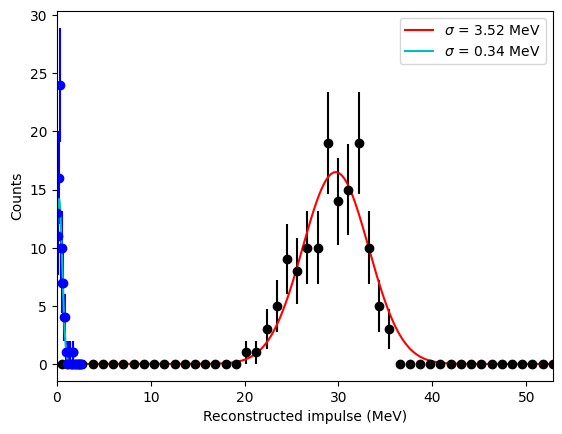

In [63]:
normed_amps = fit_amps[:,1] #/fit_amps[:,2]
bins = np.linspace(0, np.max(np.abs(normed_amps))*1.5, 50)
hh, be = np.histogram(np.abs(normed_amps), bins=bins)
bc = 0.5*(be[1:]+be[:-1])

gp, gcov = op.curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(normed_amps)), np.std(np.abs(normed_amps))])

cal_fac = impulse_amplitude/gp[1]

xx = np.linspace(0,np.max(bc),1000)

normed_noise = noise_amps[:,1] #/noise_amps[:,2]
noise_bins = np.linspace(0, np.max(np.abs(normed_noise))*1.5, 30)
hh_noise, be = np.histogram(np.abs(normed_noise), bins=noise_bins)
bc_noise = 0.5*(be[1:]+be[:-1])
errs = np.sqrt(hh_noise)
errs[errs==0] = 1
spars = [np.max(hh_noise), 0, np.std(np.abs(normed_noise))]
gp_noise, gcov_noise = op.curve_fit(gauss, bc_noise, hh_noise, p0=spars, sigma=errs)

xx_noise = np.linspace(0,np.max(bc_noise),1000)

plt.figure()
plt.errorbar(bc*cal_fac, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(xx*cal_fac, gauss(xx, *gp), 'r', label="$\sigma$ = %.2f MeV" % (gp[2]*cal_fac))
plt.errorbar(bc_noise*cal_fac, hh_noise, yerr=np.sqrt(hh_noise), fmt='bo')
plt.plot(xx_noise*cal_fac, gauss(xx_noise, *gp_noise), 'c', label="$\sigma$ = %.2f MeV" % (gp_noise[2]*cal_fac))
plt.xlim(0,np.max(bc)*cal_fac)
plt.xlabel("Reconstructed impulse (MeV)")
plt.ylabel("Counts")
plt.legend()
plt.show()


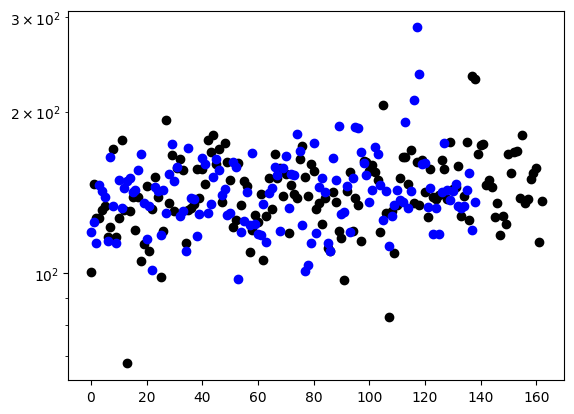

In [9]:
plt.figure()
plt.semilogy(fit_amps[:,2], 'ko')
plt.semilogy(noise_amps[:,2], 'bo')
plt.show()

In [10]:
plt.figure(figsize=(12,4))
plt.plot(filtered_data)

NameError: name 'filtered_data' is not defined

<Figure size 1200x400 with 0 Axes>